In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.notebook import tqdm

import copy
import collections

In [2]:
%config InlineBackend.figure_format = "retina"
sns.set()

# Environment

In [3]:
class Environment:

    def __init__(self, alpha=1., beta=0.2, tau=0.9, n_item=30, t_max=1000):

        self.state = np.zeros((n_item, 2))
        self.n_item = n_item
        self.t_max = t_max
        self.t = 0
        
        self.log_tau = np.log(tau)
        self.alpha = alpha
        self.beta = beta
        
    def reset(self):
        self.state = np.zeros((self.n_item, 2))
        self.t = 0
        return self.state.flatten()

    def step(self, action):
        
        self.state[:, 0] += 1
        self.state[action, 0] = 0
        self.state[action, 1] += 1
        
        reward = self.reward()

        next_state = self.state.flatten()
        done = self.is_terminal()
        self.t += 1
        
        info = {}
        return next_state, reward, done, info
    
    def reward(self):
        """
        Number of items whose probability of recall > tau
        """
        view = self.state[:, 1] > 0
        logp_recall = - self.alpha*self.state[view, 0]*(1-self.beta)**(self.state[view, 1] - 1)
        above_thr = logp_recall > self.log_tau

        return np.count_nonzero(above_thr)
    
    def play(self, action):
        """
        For MCTS rollouts
        """
        
        new_env = copy.deepcopy(self)
        next_state, reward, done, info = new_env.step(action)
        return new_env
    
    def is_terminal(self):
        """
        For MCTS expansion
        """
        return self.t == self.t_max - 1

# Threshold policy

In [4]:
class Threshold:
    """
    Present already seen item if p recall < or = tau (if several, pick lowest p)
    Otherwise present new item
    """
    def __init__(self):
        pass
    def act(self, env):
        state = env.state
        view = env.state[:, 1] > 0
        logp_recall = - env.state[view, 0]*0.8**(env.state[view, 1] - 1)
        under_thr = logp_recall <= env.log_tau
        if np.count_nonzero(under_thr) > 0:
            items = np.arange(env.n_item)
            viewed = items[view]
            action = viewed[np.argmin(logp_recall)]
        else:
            n_seen = np.count_nonzero(view)
            max_item = env.n_item-1
            action = np.min((n_seen, max_item))

        return action

In [5]:
env = Environment()
state = env.reset()
policy = Threshold()
rewards = []
actions = []
while True:
    action = policy.act(env)
    next_state, reward, done, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

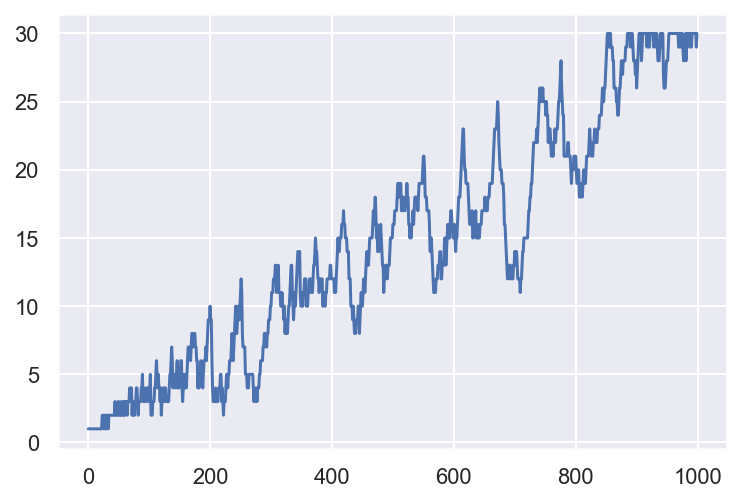

In [6]:
plt.plot(rewards);

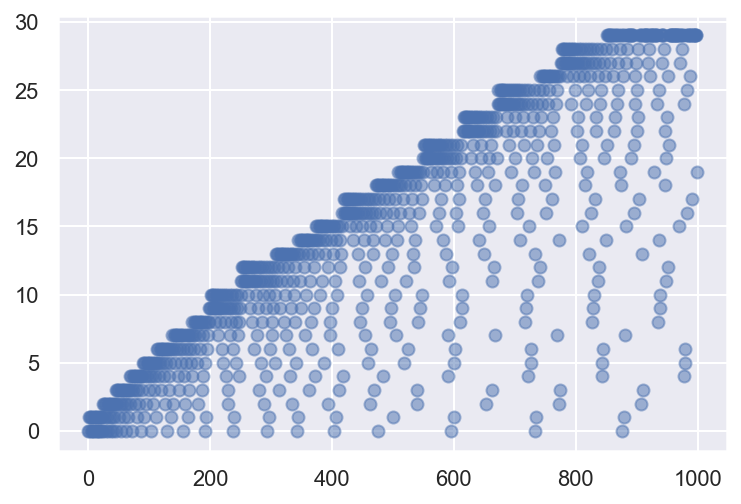

In [7]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);

# Random policy

In [8]:
env = Environment()
state = env.reset()
rewards = []
actions = []
while True:
    action = np.random.randint(env.n_item)
    next_state, reward, done, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    if done:
        break

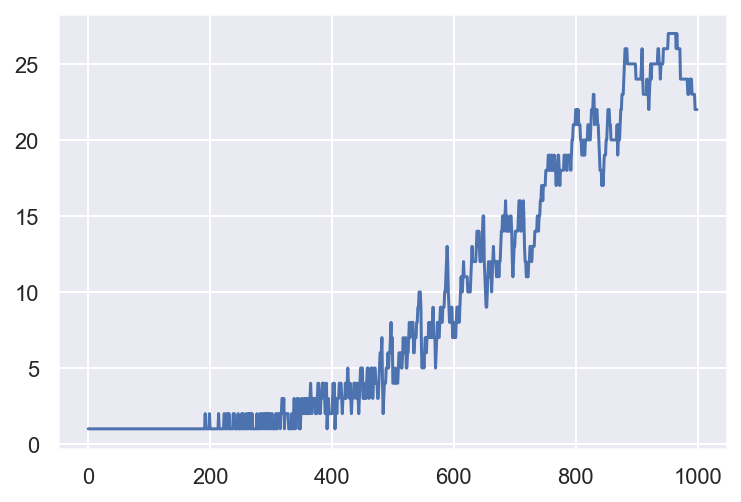

In [9]:
plt.plot(rewards);

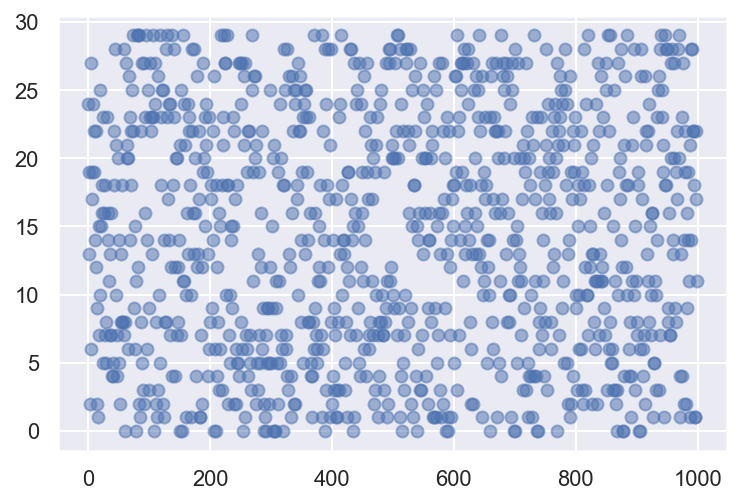

In [10]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);

# MCTS

In [11]:
class UCTNode():
    def __init__(self, game_state, move, parent=None):
        self.game_state = game_state
        self.move = move
        self.is_expanded = False
        self.parent = parent  # Optional[UCTNode]
        self.children = {}  # Dict[move, UCTNode]
        self.child_priors = np.zeros(30, dtype=np.float32)
        self.child_total_value = np.zeros(30, dtype=np.float32)
        self.child_number_visits = np.zeros(30, dtype=np.float32)

    @property
    def number_visits(self):
        return self.parent.child_number_visits[self.move]

    @number_visits.setter
    def number_visits(self, value):
        self.parent.child_number_visits[self.move] = value

    @property
    def total_value(self):
        return self.parent.child_total_value[self.move]

    @total_value.setter
    def total_value(self, value):
        self.parent.child_total_value[self.move] = value

    def child_Q(self):
        return self.child_total_value / (1 + self.child_number_visits)

    def child_U(self):
        return np.sqrt(self.number_visits) * (
                self.child_priors / (1 + self.child_number_visits))

    def best_child(self):
        return np.argmax(self.child_Q() + self.child_U())

    def select_leaf(self):
        current = self
        if not current.game_state.is_terminal():
            while current.is_expanded:
                best_move = current.best_child()
                current = current.maybe_add_child(best_move)
                if current.game_state.is_terminal():
                    break
        return current

    def expand(self, child_priors):
        self.is_expanded = True
        self.child_priors = child_priors

    def maybe_add_child(self, move):
        if move not in self.children:
            # print("add child", move)
            self.children[move] = UCTNode(
                self.game_state.play(move), move, parent=self)
        return self.children[move]

    def backup(self, value_estimate: float):
        current = self
        while current.parent is not None:
            current.number_visits += 1
#             current.total_value += (value_estimate *
#                                     self.game_state.to_play)
            current.total_value += value_estimate
            current = current.parent


class DummyNode(object):
    def __init__(self):
        self.parent = None
        self.child_total_value = collections.defaultdict(float)
        self.child_number_visits = collections.defaultdict(float)

In [12]:
class MCTS:
    def __init__(self, num_reads=10000, max_horizon=5):
        self.num_reads = num_reads
        self.max_horizon = max_horizon
    
    def act(self, env):

        action = self.UCT_search(env, self.num_reads)
        return action
    
    def UCT_search(self, game_state, num_reads):
        
        root = UCTNode(game_state, move=None, parent=DummyNode())
        for _ in range(num_reads):
            leaf = root.select_leaf()
            child_priors, value_estimate = self.evaluate(leaf.game_state)
            leaf.expand(child_priors)
            leaf.backup(value_estimate)
        return np.argmax(root.child_number_visits)
    
    def evaluate(self, env):
        
        child_priors = np.ones(30)
        
        budget = np.min((self.max_horizon, env.t_max - env.t))
        
        if budget:
            env = copy.deepcopy(env)
            env_reward = env.reward()
            
            actions = np.random.randint(env.n_item, size=budget)
            rewards = np.zeros(budget)
            for i, act in enumerate(actions):
                next_state, reward, done, info = env.step(action)
                rewards[i] = reward
            value_estimate = env_reward + rewards.sum()
        else:
            value_estimate = env_reward

        return child_priors, value_estimate

In [13]:
env = Environment(t_max=1000)
state = env.reset()
rewards = []
actions = []
policy = MCTS(num_reads=40, max_horizon=10)

with tqdm(total=env.t_max) as pbar:
    while True:
        
        action = policy.act(env)
        
        next_state, reward, done, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        
        pbar.set_postfix({"action": action, "reward": reward})
        pbar.update()
        if done:
            break

  0%|          | 0/1000 [00:00<?, ?it/s]

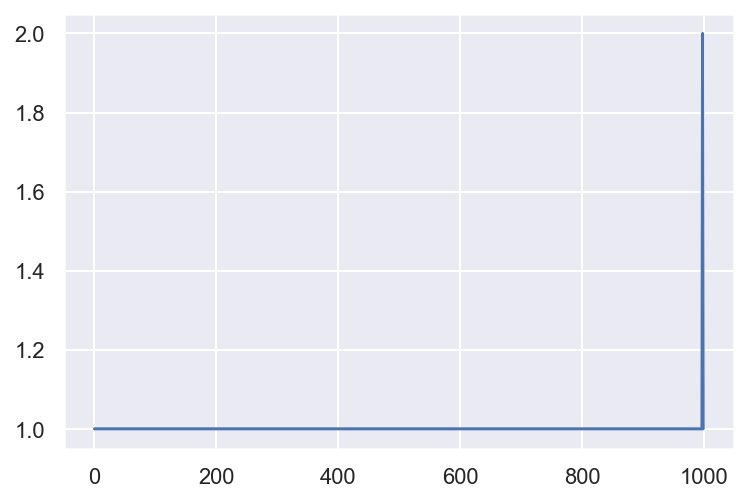

In [14]:
plt.plot(rewards);

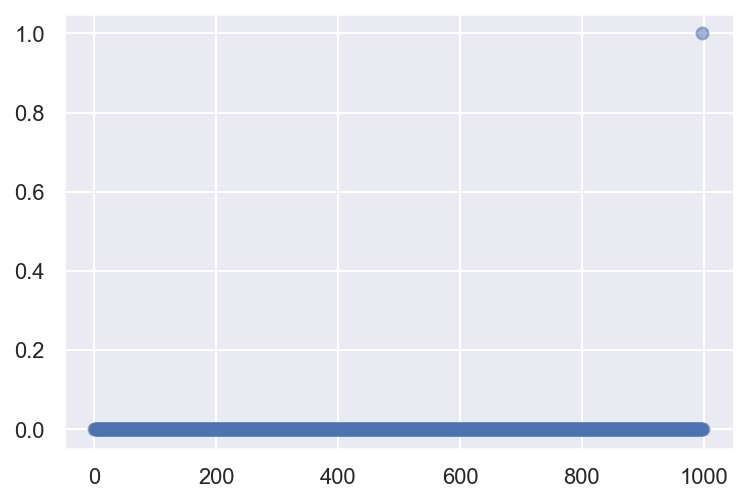

In [15]:
plt.scatter(np.arange(env.t_max), actions, alpha=0.5);